# Importing python modules

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from collections import deque

# Import video tools
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Import Python Image Library
import PIL
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw

# Line and LineHist classes

In [132]:
class Line():
    def __init__(self, coeffs=np.array([0,0,0]), valid=True, x_pix=None, y_pix=None):
        self.coeffs = coeffs
        self.valid = valid
        self.x_pix = x_pix
        self.y_pix = y_pix
        
    def radius_pix(self, y_eval):
        return ((1 + (2*self.coeffs[0]*y_eval \
                      + self.coeffs[1])**2)**(1.5)) \
                      / np.absolute(2*self.coeffs[0])
        
    def radius_m(self, y_eval=720, ym_per_pix=(30/720), xm_per_pix=(3.7/700)):
        return ((1 + (2*self.coeffs[0]*y_eval*ym_per_pix \
                      + self.coeffs[1])**2)**1.5) \
                      / np.absolute(2*self.coeffs[0])
        
    def f(self, y_eval):
        return self.coeffs[0]*y_eval**2 + self.coeffs[1]*y_eval + self.coeffs[2]

class LineHist():
    
    global DEBUG
    global DEBUG_IMG
    
    def __init__(self, histSize= 10):
        self.histSize = histSize
        self.hist_left = deque([], maxlen=histSize)
        self.hist_right = deque([], maxlen=histSize)
        
    def appendLines(self, line_left, line_right):
        result, err_code = self.sanityCheck(line_left, line_right)
        if result:
            self.hist_left.appendleft(line_left)
            self.hist_right.appendleft(line_right)
            return True, err_code
        else:
            self.hist_left.appendleft(Line(valid=False))
            self.hist_right.appendleft(Line(valid=False))
            return False, err_code
        
    def sanityCheck(self,
                    line_left,
                    line_right,
                    curvature_thresh=1.0,
                    is_straight_thresh=8000,
                    dist_thresh=(1.5, 5.0),
                    var_thresh=1.0,
                    img_height=720,
                    xm_per_pix=(3.7/700)):
        
        checkResult = True
        
        sanCheckErr = ""
        
        # check if the lines have similar curvature
        left_rad = line_left.radius_m()
        right_rad = line_right.radius_m()
        # if both lines have a curvature bigger than is_straight_thresh, we assume
        # that both lines are straight
        #if not (left_rad > is_straight_thresh) & (right_rad > is_straight_thresh):
        curv_diff = np.absolute(left_rad - right_rad) / (left_rad + right_rad)
        if not curv_diff <= curvature_thresh:
            checkResult = False
            sanCheckErr = sanCheckErr + "curvDiff " + str(curv_diff) + " "
            if DEBUG:
                print("[sanityCheck] Line rad diff too big: "
                      + str((np.absolute(left_rad - right_rad) / left_rad)))
                print("[sanityCheck] rad line left: " + str(left_rad))
                print("[sanityCheck] rad line right: " + str(right_rad))

            # check if average distance between the lines is ok
        dist_vect = xm_per_pix * (line_right.f(np.linspace(0, img_height-1, img_height)) \
                                        - line_left.f(np.linspace(0, img_height-1, img_height)))
        mean_dist = np.mean(dist_vect)
        if (mean_dist > dist_thresh[1]) | (mean_dist < dist_thresh[0]):
            checkResult = False
            sanCheckErr = sanCheckErr + "liDiff " + str(mean_dist) + " "
            if DEBUG:
                print("[sanityCheck] line mean dist out of range: " + str(mean_dist))
        
        # check if the lines are parallel
        dist_variance = np.var(dist_vect)
        if dist_variance > var_thresh:
            checkResult = False
            sanCheckErr = sanCheckErr + "diffVar " + str(dist_variance) + " "
            if DEBUG:
                print("[sanityCheck] line dist var too big: " + str(dist_variance))
            
        # check if the lines fit to the current average line
        validLineInHist = False
        for line in self.hist_left:
            validLineInHist = validLineInHist | line.valid
        if validLineInHist:
            avgLineRad = self.getAverageMiddleLine().radius_m()
            if not (((np.absolute(left_rad - avgLineRad) / (left_rad + avgLineRad)) <= curvature_thresh) \
                & ((np.absolute(right_rad - avgLineRad) / (right_rad + avgLineRad)) <= curvature_thresh)):
                checkResult = False
                sanCheckErr = sanCheckErr + "avg "
                if DEBUG:
                    print("[sanityCheck] lines don't fit avg line")
        
        if DEBUG:
            if checkResult:
                print("[sanityCheck] PASSED!")
            else:
                print("[sanityCheck] FAILED!")
        return checkResult, sanCheckErr
        
    def getAverageMiddleLine(self):
        coeff_avg = np.array([])
        for line in self.hist_left:
            if line.valid:
                coeff_avg = np.append(coeff_avg, line.coeffs)
        for line in self.hist_right:
            if line.valid:
                coeff_avg = np.append(coeff_avg, line.coeffs)

        coeff_avg = np.vstack(coeff_avg)
        return Line(np.mean(coeff_avg, axis=1))
    
    def getAverageLines(self):
        coeff_avg_left = np.array([])
        coeff_avg_right = np.array([])
        
        for line in self.hist_left:
            if line.valid:
                coeff_avg_left = np.append(coeff_avg_left, line.coeffs)
        if coeff_avg_left.size > 0:
            coeff_avg_left = np.vstack(coeff_avg_left)
            left_line = Line(np.mean(coeff_avg_left, axis=1))
        else:
            left_line = None
        
        for line in self.hist_right:
            if line.valid:
                coeff_avg_right = np.append(coeff_avg_right, line.coeffs)
        if coeff_avg_right.size > 0:
            coeff_avg_right = np.vstack(coeff_avg_right)
            right_line = Line(np.mean(coeff_avg_right, axis=1))
        else:
            right_line = None
            
        
        return left_line, right_line

# Helpers

In [3]:
# Plotting
class NamedImage:
    img = np.empty([0,0,0])
    name = ''
    
    def __init__(self, img, name):
        self.img = img
        self.name = name

def plot_multiple(plot_img_list):
    ncol = 2
    nrow = int(np.ceil(len(plot_img_list)/ncol))

    f, axes = plt.subplots(nrow, ncol, figsize=(96,36), squeeze=False)
    f.tight_layout()

    for idx, named_img in enumerate(plot_img_list):
        selected_row = int(idx / ncol)
        selected_col = int(idx % ncol)
        axes[selected_row, selected_col].imshow(named_img.img)
        axes[selected_row, selected_col].set_title(named_img.name, fontsize=14)
        
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0., wspace=0.)

# Gaussian Blur
def gaussian_smoothing(img, kernel_size=3):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

# ROI Mask
def binary_mask(img, vertices):
    mask = np.zeros_like(img)   

    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def combine_img(init_img, img, alpha=0.8, beta=1., gamma=0.):
    return cv2.addWeighted(init_img, alpha, img, beta, gamma)

def draw_lane_area(img, line_left, line_right):
    lane_area = np.zeros_like(img)
    
    y_plot = np.linspace(0, img.shape[0]-1, img.shape[0])
    x_plot_left = line_left.f(y_plot)
    x_plot_right = line_right.f(y_plot)
    
    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            if (col >= x_plot_left[row]) & (col <= x_plot_right[row]):
                lane_area[row, col] = [0,255,0]
                
    return lane_area

# Camera Calibration

In [4]:
# Number of corners in x and y direction
nx = 9
ny = 6

def cal_get_calib_params():
    cal_img_path = "./camera_cal"        
    img_points = []
    obj_points = []

    # Object points
    objp_template = np.zeros((nx*ny, 3), np.float32)
    objp_template[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
        
    for imgName in os.listdir(cal_img_path):
        #load the image
        img = cv2.imread(os.path.join(cal_img_path, imgName))
        # convert ot grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        
        if ret == True:
            img_points.append(corners)
            obj_points.append(objp_template)
    return img_points, obj_points
        
def cal_undistort(img_points, obj_points, img):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# Color Space Thresholding

In [5]:
def cst_threshold(img, channel='S', thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    if channel == 'H':
        single_channel = hls[:,:,0]
    elif channel == 'L':
        single_channel = hls[:,:,1]
    elif channel == 'S':
        single_channel = hls[:,:,2]
    binary_output = np.zeros_like(single_channel)
    binary_output[(single_channel > thresh[0]) & (single_channel <= thresh[1])] = 1
    return binary_output

# Gradient Thresholding

In [6]:
def grad_mag_thresh(img, sobel_kernel=5, thresh=(0, 255)):
    # if the image is a color image, then first convert it to gray
    if len(img.shape) > 1:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # calculate the gradient magnitude
    mag = np.sqrt(sobel_x**2 + sobel_y**2)
    # scale to a range between 0 and 255
    scaled_sobel = np.uint8(255*mag/np.max(mag))
    
    # apply the threshold and create a binary output image
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary

In [7]:
def grad_dir_thresh(img, sobel_kernel=5, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    sobelx_abs = np.absolute(sobelx)
    sobely_abs = np.absolute(sobely)

    directions = np.arctan2(sobely_abs, sobelx_abs)

    binary = np.zeros_like(directions)
    binary[(directions >= thresh[0]) & (directions <= thresh[1])] = 1

    return binary

# Pipeline for thresholded binary image

In [8]:
# Calibration
img_points, obj_points = cal_get_calib_params()

In [9]:
def line_segmentation(img):
    # Array of images, which is used to store the intermediate results of the pipeline
    plot_img_list = []

    #### Parameters ####
    # Color thresholds
    thresh_cst_h = (90,100)
    thresh_cst_l = (200,255)
    thresh_cst_s = (150,255)

    # Gradient thresholds
    # Magnitude
    thresh_grad_mag = (100,150)
    # Direction
    thresh_grad_dir = (0.7,1.3)

    # Vertices of ROI mask
    x_len = img.shape[1]
    y_len = img.shape[0]
    vertices = np.array([[[0,y_len],
                [int(x_len/2)-30,int(y_len/2)+70],
                [int(x_len/2)+30,int(y_len/2)+70],
                [x_len,y_len]]])

    img_undist = cal_undistort(img_points, obj_points, img)
    plot_img_list.append(NamedImage(img_undist, 'Undistortion'))

    img_undist = gaussian_smoothing(img, kernel_size=5)

    img_color_thresh_H = cst_threshold(img_undist, 'H', thresh_cst_h)
    plot_img_list.append(NamedImage(img_color_thresh_H, 'Color Threshold H'))

    img_color_thresh_L = cst_threshold(img_undist, 'L', thresh_cst_l)
    plot_img_list.append(NamedImage(img_color_thresh_L, 'Color Threshold L'))

    img_color_thresh_S = cst_threshold(img_undist, 'S', thresh_cst_s)
    plot_img_list.append(NamedImage(img_color_thresh_S, 'Color Threshold S'))

    img_grad_mag = grad_mag_thresh(img_undist, 5, thresh_grad_mag)
    plot_img_list.append(NamedImage(img_grad_mag, 'Gradient Magnitude Threshold'))

    img_grad_dir = grad_dir_thresh(img_undist, sobel_kernel=5, thresh=thresh_grad_dir)
    plot_img_list.append(NamedImage(img_grad_dir, 'Gradient Direction Threshold'))

    combined_grad = np.zeros_like(img_grad_dir)
    combined_grad[((img_grad_mag == 1) & (img_grad_dir == 1))] = 1
    plot_img_list.append(NamedImage(combined_grad, 'Combined Gradient Thresholds'))

    combined_col = np.zeros_like(img_color_thresh_H)
    combined_col[((img_color_thresh_H == 1) | (img_color_thresh_L == 1) | (img_color_thresh_S == 1))] = 1
    plot_img_list.append(NamedImage(combined_col, 'Combined Color Thresholds'))

    combined = np.zeros_like(img_color_thresh_H)
    combined[((combined_grad == 1) | (combined_col == 1))] = 1
    plot_img_list.append(NamedImage(combined, 'All Thresholds Combined'))

    img_masked = binary_mask(combined, vertices)
    plot_img_list.append(NamedImage(img_masked, 'ROI Mask Applied'))

    return img_masked, plot_img_list

# Perspective Transform

In [69]:
def perspective_transform(img, inverse=False):
    x_len = img.shape[1]
    y_len = img.shape[0]
    
    #src = np.float32([[200,y_len],
    #                  [595,450],
    #                  [686,450],
    #                  [1105,y_len]])
    #src = np.float32([[200,y_len],
    #                  [520,500],
    #                  [760,500],
    #                  [1105,y_len]])
    src = np.float32([[200,y_len],
                      [560,470],
                      [720,470],
                      [1105,y_len]])
    dst = np.float32([[400,y_len],
                      [400,0],
                      [880,0],
                      [880,y_len]])
    
    #plt.imshow(img)
    #plt.plot(src[0][0],src[0][1], '.')
    #plt.plot(src[1][0],src[1][1], '.')
    #plt.plot(src[2][0],src[2][1], '.')
    #plt.plot(src[3][0],src[3][1], '.')
    
    # in case we want to get the inverse transform, swap src and dst
    if inverse:
        src,dst = dst,src
        
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)

    return warped, M

# Finding the Lines

In [24]:
def find_init_line_pos(img):
    bottom_half = img[img.shape[0]//2:, :]

    hist = np.sum(bottom_half, axis = 0)

    middle = np.int(hist.shape[0]//2)
    
    x_left = np.argmax(hist[:middle])
    x_right = np.argmax(hist[middle:]) + middle
    
    return x_left, x_right

In [25]:
def find_lines_sliding_win(img, x_init_left, x_init_right):
    
    out_img = np.dstack((img*255, img*255, img*255))
    
    num_windows = 9
    win_width = 100
    min_pix = 50
    
    win_height = np.int(img.shape[0]//num_windows)
    
    nonzero = img.nonzero()
    nonzero_x = nonzero[1]
    nonzero_y = nonzero[0]
    
    x_current_left = x_init_left
    x_current_right = x_init_right
    
    idx_line_left = []
    idx_line_right = []
    
    for win in range(num_windows):
        y_low = img.shape[0] - ((win + 1) * win_height)
        y_high = img.shape[0] - (win * win_height)
        
        x_low_left = x_current_left - win_width
        x_high_left = x_current_left + win_width
        x_low_right = x_current_right - win_width
        x_high_right = x_current_right + win_width
        

        cv2.rectangle(out_img, (x_low_left, y_low), (x_high_left, y_high), (0,255,0), 5)
        cv2.rectangle(out_img, (x_low_right, y_low), (x_high_right, y_high), (0,255,0), 5)
        
        matching_idx_left = ((nonzero_y >= y_low) & (nonzero_y < y_high) & \
                             (nonzero_x >= x_low_left) & (nonzero_x < x_high_left)).nonzero()[0]
        matching_idx_right = ((nonzero_y >= y_low) & (nonzero_y < y_high) & \
                              (nonzero_x >= x_low_right) & (nonzero_x < x_high_right)).nonzero()[0]
        
        idx_line_left.append(matching_idx_left)
        idx_line_right.append(matching_idx_right)
        
        if len(matching_idx_left) > min_pix:
            x_current_left = np.int(np.mean(nonzero_x[matching_idx_left]))
        if len(matching_idx_right) > min_pix:
            x_current_right = np.int(np.mean(nonzero_x[matching_idx_right]))
            
    idx_line_left = np.concatenate(idx_line_left)
    idx_line_right = np.concatenate(idx_line_right)
    
    x_left = nonzero_x[idx_line_left]
    y_left = nonzero_y[idx_line_left]
    x_right = nonzero_x[idx_line_right]
    y_right = nonzero_y[idx_line_right]
    
    return x_left, y_left, x_right, y_right, out_img

In [26]:
def fit_polynomial(img):
    
    # Find the starting positions for the window search
    x_init_left, x_init_right = find_init_line_pos(img)
    
    # Search the lines with sliding windows
    x_left, y_left, x_right, y_right, out_img_rect = find_lines_sliding_win(img, x_init_left, x_init_right)
    
    # Fit a second order polynomial through the marked pixels
    line_left = Line(np.polyfit(y_left, x_left, 2), True, x_left, y_left)
    line_right = Line(np.polyfit(y_right, x_right, 2), True, x_right, y_right)
    
    out_img_rect[y_left, x_left] = [255,0,0]
    out_img_rect[y_right, x_right] = [0,0,255]
    
    out_img = np.zeros_like(out_img_rect)
    out_img[y_left, x_left] = [255,0,0]
    out_img[y_right, x_right] = [0,0,255]
    
    return out_img, out_img_rect, line_left, line_right

# Process Image

In [125]:
class ImgProcessor():
    
    global DEBUG
    global DEBUG_IMG
    global curv_diff_glob
    
    def __init__(self):
        self.lineHist = LineHist()
        self.font = ImageFont.truetype("fonts/Roboto-Regular.ttf", size=50)
        
    def process_image(self, img):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Segment the lane lines and get a binary image
        binary, _ = line_segmentation(img)

        # Warp the image to birdseye view
        warped, _ = perspective_transform(binary)
        
        # Fit polynomials through the lane lines
        img_poly_fit, _, line_left, line_right = fit_polynomial(warped)
        
        # Append the lines to the line history
        lines_appended_b, err_code = self.lineHist.appendLines(line_left, line_right)

        line_left, line_right = self.lineHist.getAverageLines()
        
        # If no lines are found, just return the image
        if not ((line_left== None) | (line_right == None)):
        
            ###############
            ### DRAWING ###
            ###############

            # Unwarp the image, that marks the lane lines
            unwarped_lines, _ = perspective_transform(img_poly_fit, inverse=True)
            # Unwarp the image, that marks the lane area
            img_lane_area = draw_lane_area(img, line_left, line_right)
            unwarped_area, _ = perspective_transform(img_lane_area, inverse=True)

            # Combine the results with the original image
            img = combine_img(img, unwarped_area, alpha=0.8, beta=.5, gamma=0.)
            img[unwarped_lines[:,:,0] == 255] = [255,0,0]
            img[unwarped_lines[:,:,2] == 255] = [0,0,255]
            
            PIL_img = Image.fromarray(img)
            draw = ImageDraw.Draw(PIL_img)
            draw.text((100, 50),("Lane Radius: " + str(line_left.radius_m(img.shape[0]))),(0,0,255), font=self.font)
            draw = ImageDraw.Draw(PIL_img)
            img = np.asarray(PIL_img)
            
        if DEBUG_IMG:
            validCtr = 0
            for line in self.lineHist.hist_left:
                if line.valid:
                    validCtr = validCtr + 1

            PIL_img = Image.fromarray(img)
            draw = ImageDraw.Draw(PIL_img)
            draw.text((100, 100),("Line hist len: " + str(validCtr)),(0,0,255), font=self.font)
            draw.text((100, 150),("SanCheckErr: " + str(err_code)),(0,0,255), font=self.font)
            if lines_appended_b:
                appended_text = "Appended"
            else:
                appended_text = "Not Appended"
            draw.text((100, 200),(appended_text),(0,0,255), font=self.font)
            draw = ImageDraw.Draw(PIL_img)
            img = np.asarray(PIL_img)
        
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        return img

# Main

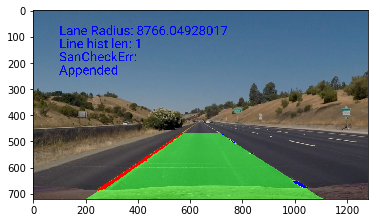

In [126]:
def main():
    img_proc = ImgProcessor()
    # load test image
    img = cv2.imread('test_images/straight_lines1.jpg')
    img = img_proc.process_image(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    
DEBUG = False
DEBUG_IMG = True
main()

In [133]:
img_proc = ImgProcessor()

video_output = './output_video/project_video.mp4'
clip1 = VideoFileClip("./project_video.mp4")
#.subclip(38,42)
video_clip = clip1.fl_image(img_proc.process_image)
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./output_video/project_video.mp4
[MoviePy] Writing video ./output_video/project_video.mp4



 12%|█▏        | 152/1261 [03:47<27:51,  1.51s/it]


 24%|██▍       | 303/1261 [07:36<24:21,  1.53s/it]


 36%|███▌      | 454/1261 [11:25<20:29,  1.52s/it]


 48%|████▊     | 605/1261 [15:18<17:16,  1.58s/it]


 60%|█████▉    | 756/1261 [19:07<12:39,  1.50s/it]


 72%|███████▏  | 907/1261 [22:58<09:00,  1.53s/it]


 84%|████████▍ | 1057/1261 [26:50<05:17,  1.56s/it]


 96%|█████████▌| 1205/1261 [30:38<01:25,  1.54s/it]


100%|█████████▉| 1260/1261 [32:03<00:01,  1.55s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video/project_video.mp4 

CPU times: user 28min 41s, sys: 1min 9s, total: 29min 50s
Wall time: 32min 6s


In [16]:
img_proc = ImgProcessor()

video_output = './output_video/challenge_video.mp4'
clip1 = VideoFileClip("./challenge_video.mp4")
#.subclip(0,1)
video_clip = clip1.fl_image(img_proc.process_image)
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./output_video/challenge_video.mp4
[MoviePy] Writing video ./output_video/challenge_video.mp4


 69%|██████▊   | 333/485 [06:36<03:49,  1.51s/it]

TypeError: expected non-empty vector for x

In [17]:
img_proc = ImgProcessor()

video_output = './output_video/harder_challenge_video.mp4'
clip1 = VideoFileClip("./harder_challenge_video.mp4")
#.subclip(0,1)
video_clip = clip1.fl_image(img_proc.process_image)
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./output_video/harder_challenge_video.mp4
[MoviePy] Writing video ./output_video/harder_challenge_video.mp4



 25%|██▌       | 303/1200 [06:25<24:25,  1.63s/it]


 50%|█████     | 605/1200 [12:42<15:18,  1.54s/it]


 76%|███████▌  | 907/1200 [18:57<07:14,  1.48s/it]


100%|█████████▉| 1199/1200 [24:13<00:01,  1.53s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video/harder_challenge_video.mp4 

CPU times: user 20min 39s, sys: 56.4 s, total: 21min 35s
Wall time: 24min 17s
